In [140]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, df, scf, lo, dft
import plotly.graph_objects as go

In [141]:
# Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, 
# Κ κ, Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, Σ σ,
# Τ τ, Υ υ, Φ φ, Χ χ, Ψ ψ, Ω ω.

In [142]:
_ = """
      O       1.596302       6.920128       0.656695
      O       3.280398      10.146539       6.088696
      O       2.251703       3.406261       8.769908
      O       2.596302       7.920128       1.656695
      H       1.762019       9.820429       5.528454
      H       3.095987       9.107088       5.588186
      H       0.554129       2.982634       8.082024
      H       1.771257       2.954779       7.182181
      H       2.112148       6.126321       0.798136
      H       1.776389       7.463264       1.424030
      H       2.762019      10.820429       6.528454
      H       4.095987      10.107088       6.588186
      H       1.554129       3.982634       9.082024
      H       2.771257       3.954779       8.182181
      H       3.112148       7.126321       1.798136
      H       2.776389       8.463264       2.424030
"""

'\n      O       1.596302       6.920128       0.656695\n      O       3.280398      10.146539       6.088696\n      O       2.251703       3.406261       8.769908\n      O       2.596302       7.920128       1.656695\n      H       1.762019       9.820429       5.528454\n      H       3.095987       9.107088       5.588186\n      H       0.554129       2.982634       8.082024\n      H       1.771257       2.954779       7.182181\n      H       2.112148       6.126321       0.798136\n      H       1.776389       7.463264       1.424030\n      H       2.762019      10.820429       6.528454\n      H       4.095987      10.107088       6.588186\n      H       1.554129       3.982634       9.082024\n      H       2.771257       3.954779       8.182181\n      H       3.112148       7.126321       1.798136\n      H       2.776389       8.463264       2.424030\n'

In [143]:
mol_h2o = gto.M(atom = """
      O       2.280398       0.146539       0.088696;
      H       1.762019       0.820429       0.528454;
      H       3.095987       0.107088       0.588186;
      O       1.251703       2.406261       1.769908;
      H       0.554129       2.982634       2.082024;
      H       1.771257       2.954779       1.182181;""")
mol_h2o.basis = '631g'
mol_h2o.build()
# Computes the 4 centre 2 electrons integrals (using Rys)
ref_μνλσ = mol_h2o.intor("int2e")

# Computes the integrals using RI
## (1) define the aux basis set.
## See https://pyscf.org/pyscf_api_docs/pyscf.df.html#pyscf.df.addons.make_auxmol
## for info about the automatic choice of aux basis set
Amol = df.addons.make_auxmol(mol_h2o)
Amol.build()
## (2) computes the cholesky of the inverse of the 2 centre 2 electrons integrals
A = Amol.intor("int2c2e",comp=1)
AL = np.linalg.cholesky(np.linalg.inv(A))
## (3) Computes the 3 centre integrals between the system and the aux
μνQ = df.incore.aux_e2(mol_h2o, Amol, intor="int3c2e")
B = np.einsum('ijQ,QP->ijP',μνQ,AL)
## (4) Computes the 4 centre integrals
μνλσ = np.einsum('ijP,klP',B,B)

# How good was the approximation
print('Basis set', mol_h2o.basis)
print('Aux basis set', Amol.basis)
print("ERI MAX ABS DIF:" , np.max(np.abs(μνλσ-ref_μνλσ)))
print("ERI AVE ABS DIF:" , np.mean(np.abs(μνλσ-ref_μνλσ)))

Basis set 631g
Aux basis set {'H': 'cc-pvdz-jkfit', 'O': 'cc-pvdz-jkfit'}
ERI MAX ABS DIF: 0.00018170664728967
ERI AVE ABS DIF: 2.1011486879963274e-07


In [152]:
mf = scf.RHF(mol_h2o).run()
dm = mf.make_rdm1()

converged SCF energy = -151.976750024724


In [145]:
mol_h2o.atom_coords()[0]

array([4.30932768, 0.27691858, 0.16761115])

In [161]:
grid = []
R = 32

x0,y0,z0 = mol_h2o.atom_coords()[0]

for x in np.linspace( -2, 6, R ):
    for y in np.linspace( -2, 6, R ):
        for z in np.linspace( -2, 6, R ):
            grid.append([x,y,z])
grid = np.array(grid)

orbs = np.zeros( shape=(grid.shape[0], mol_h2o.nao ) )
#for ip, p in enumerate(grid):
#    orbs [ip] = mol_h2o.eval_gto('GTOval', [p])
orbs = mol_h2o.eval_gto('GTOval', grid)
ao = dft.numint.eval_ao(mol_h2o, grid, deriv=0)
rho = dft.numint.eval_rho(mol_h2o, ao, dm)
#orbs = orbs.reshape( (16,16,16,mol_h2o.nao) )
grid.shape

(32768, 3)

In [216]:


x,y,z = grid.T

fig = go.Figure()
fig.add_trace( go.Isosurface(
    x=x,y=y,z=z,
    value=1./(rho),
    isomin=0,isomax=4,surface_count=7,
    caps=dict(x_show=False, y_show=False, z_show=False),
    opacity=0.1
))

c = {16:'red',1:'black'}
for pos, mass in zip(mol_h2o.atom_coords(), mol_h2o.atom_mass_list()):
    fig.add_trace(go.Scatter3d(
            mode='markers',
            x=[pos[0]],
            y=[pos[1]],
            z=[pos[2]],
            marker=dict(size=[mass+10],sizemode='diameter', color=c[mass])
        )
    )

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()


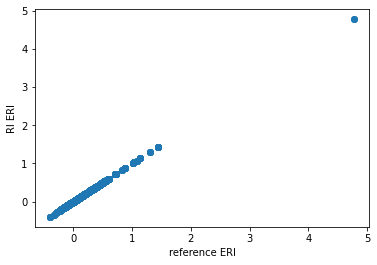

In [8]:
plt.scatter(μνλσ.flatten(), ref_μνλσ.flatten())
plt.xlabel("reference ERI")
plt.ylabel("RI ERI")
plt.show()

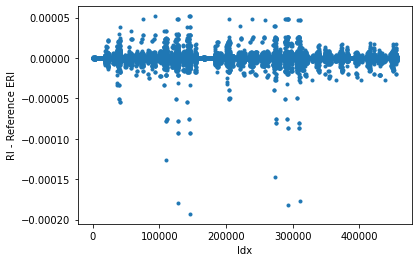

In [9]:
diff = μνλσ.flatten() - ref_μνλσ.flatten()
plt.plot(diff, '.')
plt.xlabel("Idx")
plt.ylabel("RI - Reference ERI")
plt.show()

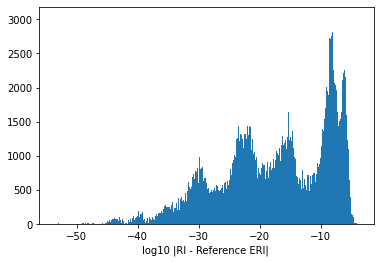

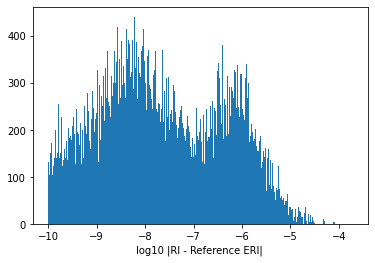

In [10]:
diff = μνλσ.flatten() - ref_μνλσ.flatten()
diff = diff[np.where(diff != 0 )]
diff = np.log10(np.abs(diff))

plt.hist(diff, bins=int(np.sqrt(diff.size)))
plt.xlabel( "log10 |RI - Reference ERI| " )
plt.show()

plt.hist(diff[np.where(diff>-10)], bins=int(np.sqrt(diff.size)))
plt.xlabel( "log10 |RI - Reference ERI| " )
plt.show()


In [11]:
tol = 1.e-4
p = 0
n = ref_μνλσ.shape[0]
n2,n3 = n**2,n**3
rr = ref_μνλσ.flatten()
vv = μνλσ.flatten()
for idx, r in enumerate(rr):
    v = vv[idx]
    if np.abs(v-r) > tol :
        i,j,k,l = idx//n3, (idx//n2)%n, (idx//n)%n, idx%n
        if p == 0 :
            print("IDX IJKL REF VAL DIF REL")
        print(idx, i,j,k,l,  r, v, r-v, (r-v)/(0.5*(np.abs(r+v)+np.abs(r-v))))
        p += 1
        if p == 32:
            break


IDX IJKL REF VAL DIF REL
109674 6 6 6 6 0.47883560463108976 0.47870880260051524 0.00012680203057452433 0.00026481328737493665
127953 7 7 7 7 0.47883560463108976 0.4786564116897566 0.00017919294133317276 0.0003742264351274144
146232 8 8 8 8 0.47883560463108976 0.4786425832524899 0.0001930213785998891 0.0004031057355239883
274185 15 15 15 15 0.47883560463108976 0.4786887896839801 0.00014681494710966358 0.00030660825070177167
292464 16 16 16 16 0.47883560463108976 0.4786542135243865 0.00018139110670328806 0.00037881708241607797
310743 17 17 17 17 0.47883560463108976 0.4786585238829083 0.00017708074818145736 0.0003698153321699752


In [12]:
Amol._bas

array([[  0,   0,   1,   1,   0,  62,  63,   0],
       [  0,   0,   1,   1,   0,  64,  65,   0],
       [  0,   0,   1,   1,   0,  66,  67,   0],
       [  0,   0,   1,   1,   0,  68,  69,   0],
       [  0,   0,   1,   1,   0,  70,  71,   0],
       [  0,   0,   1,   1,   0,  72,  73,   0],
       [  0,   0,   1,   1,   0,  74,  75,   0],
       [  0,   0,   1,   1,   0,  76,  77,   0],
       [  0,   0,   1,   1,   0,  78,  79,   0],
       [  0,   0,   1,   1,   0,  80,  81,   0],
       [  0,   1,   1,   1,   0,  82,  83,   0],
       [  0,   1,   1,   1,   0,  84,  85,   0],
       [  0,   1,   1,   1,   0,  86,  87,   0],
       [  0,   1,   1,   1,   0,  88,  89,   0],
       [  0,   1,   1,   1,   0,  90,  91,   0],
       [  0,   1,   1,   1,   0,  92,  93,   0],
       [  0,   1,   1,   1,   0,  94,  95,   0],
       [  0,   2,   1,   1,   0,  96,  97,   0],
       [  0,   2,   1,   1,   0,  98,  99,   0],
       [  0,   2,   1,   1,   0, 100, 101,   0],
       [  0,   2,   

In [18]:
mol_h2o._bas[np.where(mol_h2o._bas[:,0]==0)]

array([[ 0,  0,  6,  1,  0, 52, 58,  0],
       [ 0,  0,  3,  1,  0, 64, 67,  0],
       [ 0,  0,  1,  1,  0, 70, 71,  0],
       [ 0,  1,  3,  1,  0, 72, 75,  0],
       [ 0,  1,  1,  1,  0, 78, 79,  0]], dtype=int32)